# Предсказание стартапов

Привет!

В общем я не успел доделать работу нормально

Из того что нужно сделать и что сделает наибольший буст – как-то работать с текстами и category_list, потому что есть такая гипотеза у меня, что корреляция с целевым признаком имеется. Доделаю работу до 31.05 до своего приемлемого уровня. Это я для себя и с запасом. Будет интересно посмотреть финальную трансляцию 



Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

## 1.1 Загрузка данных


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    FunctionTransformer, 
    OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn import set_config

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV


# загружаем функции для работы с метриками

from sklearn.metrics import (
    r2_score,
    mean_squared_error, 
    mean_absolute_error,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
    
)

from phik import resources, phik_matrix
from phik.report import plot_correlation_matrix

In [2]:
!pip install shap -q

In [3]:
import shap

In [4]:
# параметр для train_test_split
RANDOM_STATE = 42

In [131]:


# Пути к файлам
path1a, path1b = '/datasets/train.csv', 'datasets/train.csv'
path2a, path2b = '/datasets/test.csv', 'datasets/test.csv'
path3a, path3b = '/datasets/sample_submit.csv', 'datasets/sample_submit.csv'



if os.path.exists(path1a):
    df = pd.read_csv(path1a)
elif os.path.exists(path1b):
    df = pd.read_csv(path1b)
else:
    print('something is wrong with df_train.csv')

if os.path.exists(path2a):
    test = pd.read_csv(path2a, delimiter=',')
elif os.path.exists(path2b):
    test = pd.read_csv(path2b, delimiter=',')
else:
    print('something is wrong with test.csv')

if os.path.exists(path3a):
    sample = pd.read_csv(path3a)
elif os.path.exists(path3b):
    sample = pd.read_csv(path3b)
else:
    print('something is wrong with sample.csv')



25018   1983-10-06
5878    1983-12-14
19862   1985-05-19
7503    1985-07-02
10169   1986-04-30
           ...    
52511          NaT
52512          NaT
52513          NaT
52514          NaT
52515          NaT
Name: closed_at, Length: 52516, dtype: datetime64[ns]


## 1.2 Проверка, очистка и преобразование данных

In [6]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [7]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [8]:
sample.head()

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [11]:
def preprocessing_display_002(df):
    num_rows = df.shape
    print(f"Общее количество строк в DataFrame: {num_rows}")
    num_null = 0
    num_null = df.isnull().sum().sum()
    print(f'Количество пропусков: {num_null}')
    duplicates = df.duplicated()
    duplicate_rows = df[duplicates]
    num_duplicates = duplicates.sum()
    print(f'Количество строк-дубликатов: {num_duplicates}')
    if num_null != 0:
        print('-' * 40)
        columns_with_na = df.columns[df.isna().any()].tolist()

        # Создание нового DataFrame, содержащего только 'id' и столбцы с пропусками
        #df_with_na = df[['id'] + columns_with_na]
        #print(df_with_na[df_with_na.isna().any(axis=1)])
        #print('-' * 40)
    for column in df.columns:
        print(f"Столбец '{column}':")
        print(f"Тип данных: {df[column].dtype}")
        print(f"Количество уникальных значений: {df[column].nunique()}")
        print(f"Уникальные значения: {df[column].unique()}")
        
        print('-' * 40)
    

In [12]:
preprocessing_display_002(df)

Общее количество строк в DataFrame: (52516, 13)
Количество пропусков: 85117
Количество строк-дубликатов: 0
----------------------------------------
Столбец 'name':
Тип данных: object
Количество уникальных значений: 52515
Уникальные значения: ['Lunchgate' 'EarLens' 'Reviva Pharmaceuticals' ... 'Taskforce'
 'NetScaler' 'Apparcando']
----------------------------------------
Столбец 'category_list':
Тип данных: object
Количество уникальных значений: 22105
Уникальные значения: ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']
----------------------------------------
Столбец 'funding_total_usd':
Тип данных: float64
Количество уникальных значений: 15551
Уникальные значения: [  828626. 42935019. 35456381. ...  4582414.  3209000.   270820.]
----------------------------------------
Столбец 'status':
Тип данных: object
Количество 

In [13]:
df[df['name'].isna()]


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [14]:
df['funding_total_usd'].head(15)


0       828626.0
1     42935019.0
2     35456381.0
3     22250000.0
4            NaN
5      4300000.0
6     90000000.0
7      4300000.0
8     42000000.0
9      1250500.0
10           NaN
11    20000000.0
12      107239.0
13     1100000.0
14      335000.0
Name: funding_total_usd, dtype: float64

In [15]:
# Столбец выглядит как 1.0, 2.0, 3.0 (т.е. по смыслу это целые числа).
# Это упрощает модель, ускоряет обучение, экономит память.
# Нужно обработать для этого значения nan

In [16]:
df[df['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-03-11,2008-07-15,2008-07-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaN
52502,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2007-04-28,2008-01-01,2008-01-01,NaN
52507,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaN
52508,ScramCard,NaN,NaN,operating,HKG,NaN,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaN


In [17]:
# Проверим неточности
df[df['status'] == 'operating']['closed_at'].isna().all()

np.True_

In [18]:
# Проверим неточности
df[(df['status'] == 'operating') & (df['closed_at'].notna())]


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


**Противоречий нет**

In [161]:
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')

In [162]:
df['closed_at'] = pd.to_datetime(df['closed_at'], errors='coerce')

In [163]:
# заменим nan на фиксированную дату

df
df['closed_at_filled'] = df.apply(
    lambda row: pd.to_datetime('2018-01-01') if pd.isna(row['closed_at']) else row['closed_at'],
    axis=1
)

# создаём столбец lifetime в днях
df['lifetime'] = (df['closed_at_filled'] - df['founded_at']).dt.days


In [164]:
df.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,country_code_encoded,closed_at_filled,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0.000076,2018-01-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0.565943,2018-01-01,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0.000762,2018-01-01,4383
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,0.565943,2018-01-01,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0.028114,2018-01-01,2791
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaT,NaN,2018-01-01,2452
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaT,0.565943,2018-01-01,6575
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaT,NaN,2018-01-01,4748
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaT,0.565943,2018-01-01,5479
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaT,0.565943,2018-01-01,2922


In [23]:
df.query("status == 'operating'").count()


name                 47599
category_list        45863
funding_total_usd    38555
status               47599
country_code         43383
state_code           42230
region               42607
city                 42607
funding_rounds       47599
founded_at           47599
first_funding_at     47599
last_funding_at      47599
closed_at                0
closed_at_filled     47599
lifetime             47599
dtype: int64

In [24]:
df.query("status == 'closed'").count()


name                 4916
category_list        4188
funding_total_usd    3892
status               4917
country_code         3631
state_code           3523
region               3550
city                 3550
funding_rounds       4917
founded_at           4917
first_funding_at     4917
last_funding_at      4917
closed_at            4917
closed_at_filled     4917
lifetime             4917
dtype: int64

In [25]:
df.query("status == 'operating'").shape[0]


47599

дисбаланс классов

In [27]:
#df = df.drop(columns=['founded_at', 'closed_at', 'closed_at_filled'])


In [28]:
#df.head()

в test нет столбцов founded_at, closed_at, status(target признак)
в df нет столбца lifetime

Добавил lifetime в df. Удалять founded_at, closed_at, closed_at_filled не буду, но в обучение они не пойдут

In [29]:
test[test['funding_total_usd'].isna()].shape[0]


2578

In [30]:
df[df['funding_total_usd'].isna()].shape[0]



10069

In [31]:
df[df['lifetime'].isna()].shape[0]


0

In [32]:
test[test['lifetime'].isna()].shape[0]


0

In [33]:
# добавим столбец avg_usd_day, где avg_usd_day = funding_total_usd / lifetime
# nan заполним позже
df.query("lifetime == 0")

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,closed_at_filled,lifetime


In [166]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,avg_usd_day,funding_span
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,805.255641,0
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,NaN,0
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,330.700386,126
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,7308.340354,1935
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,729.586085,0


In [165]:
df['avg_usd_day'] = df['funding_total_usd'] / df['lifetime']
test['avg_usd_day'] = test['funding_total_usd'] / test['lifetime']

In [167]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,country_code_encoded,closed_at_filled,lifetime,avg_usd_day
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0.000076,2018-01-01,2998,276.392929
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0.565943,2018-01-01,4748,9042.758846
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0.000762,2018-01-01,4383,8089.523386
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,0.565943,2018-01-01,5114,4350.801721
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0.028114,2018-01-01,2791,NaN


Надо исследовательский делать. Без графиков не знаю чем лучше заполнить nan в столбцах.

идеи такие. заполнить funding_total_usd mean/median

написать еще

## 3. Исследовательский анализ данных (EDA)

In [35]:
df.describe()

,funding_total_usd,funding_rounds,founded_at,closed_at,closed_at_filled,lifetime,avg_usd_day
count,4.244700e+04,52516.000000,52516,4917,52516,52516.000000,4.244700e+04
mean,1.824748e+07,1.740670,2008-11-04 09:44:16.196206848,2012-01-16 16:14:21.012812544,2017-06-11 05:36:46.504684032,3140.828129,5.371071e+03
min,1.000000e+00,1.000000,1970-02-05 00:00:00,1983-10-06 00:00:00,1983-10-06 00:00:00,19.000000,6.993007e-04
25%,3.360275e+05,1.000000,2006-10-01 00:00:00,2009-09-18 00:00:00,2018-01-01 00:00:00,1739.000000,1.511510e+02
50%,2.000000e+06,1.000000,2010-10-01 00:00:00,2012-09-15 00:00:00,2018-01-01 00:00:00,2557.000000,7.604563e+02
75%,1.000000e+07,2.000000,2013-01-01 00:00:00,2015-04-23 00:00:00,2018-01-01 00:00:00,4018.000000,3.080082e+03
max,3.007950e+10,19.000000,2016-04-02 00:00:00,2017-10-21 00:00:00,2018-01-01 00:00:00,17378.000000,3.318078e+06
std,1.871173e+08,1.374522,NaN,NaN,NaN,2147.821070,3.893460e+04


In [36]:
def eda_reseach_int_002(df, columns):
    
    for column in columns:
        if column != 'id':
            plt.figure(figsize=(12, 4))

            # Гистограмма через plt
            plt.subplot(1, 2, 1)
            plt.hist(df[column], bins=10, edgecolor='black', alpha=0.7)  # Строим гистограмму
            plt.title(f'Гистограмма')  # Заголовок
            plt.xlabel(column)  # Подпись по оси X
            plt.ylabel('Частота')  # Подпись по оси Y

            # Box plot через plt
            plt.subplot(1, 2, 2)
            plt.boxplot(df[column], vert=False)  # vert=False для горизонтального ящика с усами
            plt.title(f'Ящик с усами')
            plt.xlabel(column)  # Подпись оси X (значения признака)
            plt.ylabel('')  # Убираем подпись оси Y, так как boxplot одномерный
            plt.show()

In [37]:
df['avg_usd_day'].head(20)

0       276.392929
1      9042.758846
2      8089.523386
3      4350.801721
4              NaN
5      1753.670473
6     13688.212928
7       905.644482
8      7665.632415
9       427.960301
10             NaN
11     2607.561930
12      150.194678
13      501.824818
14      229.295003
15       17.331023
16             NaN
17    15054.744526
18      145.448323
19     1425.757013
Name: avg_usd_day, dtype: float64

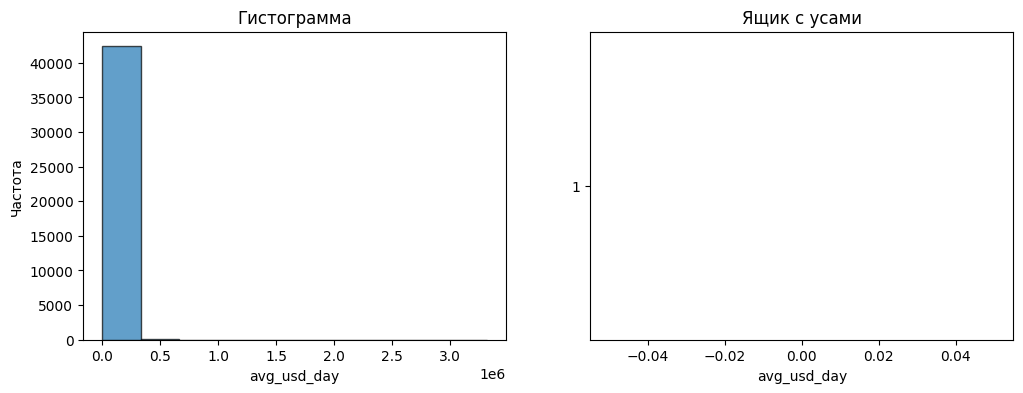

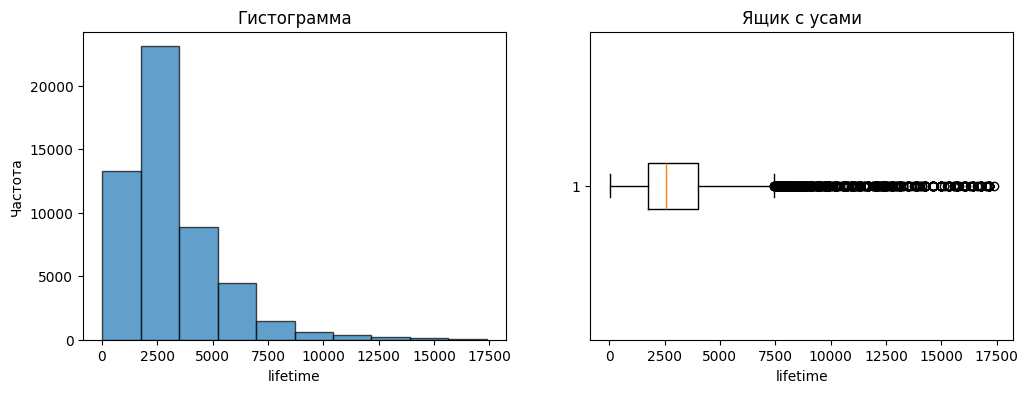

In [38]:
interval_columns1 = ['avg_usd_day', 'lifetime']

eda_reseach_int_002(df, interval_columns1)


In [39]:
def eda_research_discrete_001(df, columns):
    for column in columns:
        plt.figure(figsize=(18, 5))
        sns.countplot(x=df[column])
        plt.title(f'Распределение')  # Заголовок
        plt.ylabel('Частота')
        plt.xlabel(column)
        plt.show()

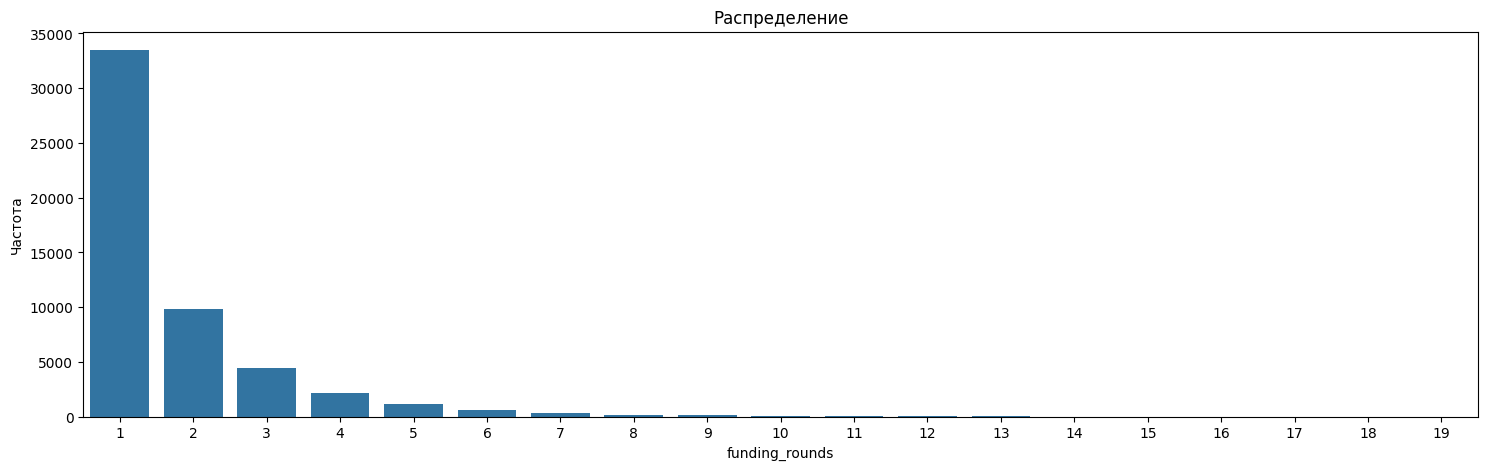

In [40]:

eda_research_discrete_001(df, ['funding_rounds'])

In [41]:
df['funding_rounds'].unique()

array([ 2,  4,  3,  1,  5,  7,  9,  6,  8, 10, 11, 12, 15, 13, 16, 17, 14,
       18, 19])

In [42]:
df.query("funding_rounds >= 5 and status == 'closed'")

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,closed_at_filled,lifetime,avg_usd_day
1024,Soteira,Health Care,10850948.0,closed,USA,MA,Boston,Natick,6,2004-01-01,2009-04-23,2012-05-25,2014-04-03,2014-04-03,3745,2897.449399
1065,Homejoy,Hospitality,39700000.0,closed,USA,CA,SF Bay Area,San Francisco,5,2012-07-01,2010-03-01,2013-12-05,2015-09-02,2015-09-02,1158,34283.246978
1305,SpectraFluidics,Hardware + Software,2502820.0,closed,USA,CA,Santa Barbara,Goleta,5,2008-11-23,2009-10-01,2012-01-18,2013-11-24,2013-11-24,1827,1369.906951
1949,Stellar Biotechnologies,Biotechnology,17566976.0,closed,USA,CA,CA - Other,Port Hueneme Cbc Base,6,1999-01-01,2010-04-22,2013-09-23,2014-12-22,2014-12-22,5834,3011.137470
2127,Bioconnect Systems,Biotechnology,19024912.0,closed,USA,PA,Philadelphia,Ambler,5,2006-01-01,2006-07-24,2013-09-25,2015-01-10,2015-01-10,3296,5772.121359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50889,Local.com,Advertising,36500000.0,closed,USA,CA,Anaheim,Irvine,5,1999-01-01,2007-02-01,2013-04-11,2014-09-04,2014-09-04,5725,6375.545852
51495,RadioFrame,Mobile|Wireless,95369999.0,closed,USA,WA,Seattle,Redmond,5,2000-04-30,2001-06-22,2008-08-29,2010-02-14,2010-02-14,3577,26662.006989
51633,Quirky,Crowdsourcing|E-Commerce,185325006.0,closed,USA,NY,New York City,New York,8,2009-03-01,2006-07-06,2014-12-09,2016-06-19,2016-06-19,2667,69488.191226
51782,Sonitus Medical,Health Care,67641704.0,closed,USA,CA,SF Bay Area,San Mateo,6,2006-01-01,2006-09-08,2014-04-28,2015-08-02,2015-08-02,3500,19326.201143


In [43]:
# Настройка отображения всех строк
#pd.set_option('display.max_rows', None)
# Сброс настроек отображения строк до значений по умолчанию
pd.reset_option('display.max_rows')
# отключить сокращение вывода numpy-массивов
#np.set_printoptions(threshold=np.inf)

np.set_printoptions(threshold=30)


In [44]:
test_col = df['category_list'].unique()

In [45]:
df['category_list'].nunique()

22105

In [46]:
df.shape[0]

52516

In [47]:
df['category_list'].shape[0]

52516

In [48]:
df['name'].nunique()

52515

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['cat_list_clean'] = df['category_list'].fillna('').str.replace(' ', '_').str.replace('|', ' ')
vectorizer1 = TfidfVectorizer(max_features=1000)
X_cat_tfidf1 = vectorizer1.fit_transform(df['cat_list_clean'])


In [52]:
df['cat_list_clean'].head()

0          Online_Reservations Restaurants
1    Manufacturing Medical Medical_Devices
2                            Biotechnology
3                              Health_Care
4                            Manufacturing
Name: cat_list_clean, dtype: object

In [53]:
X_cat_tfidf1

<52516x871 sparse matrix of type '<class 'numpy.float64'>'
	with 122885 stored elements in Compressed Sparse Row format>

In [54]:
df.query("lifetime > 7500").shape[0]

2209

In [55]:
df.query("lifetime > 7500 and status == 'operating'").shape[0]

2157

In [56]:
df.query("lifetime > 7500 and status == 'closed'").shape[0]

52

In [57]:
df.query("4 < funding_rounds < 9 and status == 'operating'").head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,closed_at_filled,lifetime,avg_usd_day,cat_list_clean
19,Cipher Surgical,Health Care,4.475451e+06,operating,GBR,C7,Coventry,Coventry,5,2009-05-29,2011-04-22,2015-04-01,NaT,2018-01-01,3139,1425.757013,Health_Care
20,Fisoc,Banking|Finance|Loyalty Programs,5.099043e+07,operating,USA,TX,Austin,Austin,7,2009-01-01,2010-06-10,2014-04-01,NaT,2018-01-01,3287,15512.756009,Banking Finance Loyalty_Programs
68,Geostellar,Analytics|Big Data|Clean Energy|Clean Technolo...,1.825000e+07,operating,USA,VA,"Washington, D.C.",Reston,5,2011-02-22,2011-04-05,2015-10-01,NaT,2018-01-01,2505,7285.429142,Analytics Big_Data Clean_Energy Clean_Technolo...
112,Fragmob,Direct Sales|Mobile|Software|Video,9.150000e+06,operating,USA,CA,San Diego,San Diego,6,2007-08-22,2010-01-01,2015-09-17,NaT,2018-01-01,3785,2417.437252,Direct_Sales Mobile Software Video
115,Crossfader,Digital Media|Entertainment|Media|Mobile|Music...,5.400000e+06,operating,USA,CA,SF Bay Area,San Francisco,6,2012-06-01,2012-09-01,2014-07-17,NaT,2018-01-01,2040,2647.058824,Digital_Media Entertainment Media Mobile Music...
146,Sakti3,Hardware + Software,5.020000e+07,operating,USA,MI,Detroit,Ann Arbor,6,2007-01-01,2009-01-01,2015-03-15,NaT,2018-01-01,4018,12493.777999,Hardware_+_Software
167,Force10 Networks,E-Commerce,2.550678e+08,operating,USA,CA,SF Bay Area,San Jose,6,1999-01-01,2003-02-01,2009-12-09,NaT,2018-01-01,6940,36753.282709,E-Commerce
194,Taulia,Enterprise Software|Hardware + Software|SaaS,9.070000e+07,operating,USA,CA,SF Bay Area,San Francisco,7,2009-01-01,2010-12-06,2015-01-21,NaT,2018-01-01,3287,27593.550350,Enterprise_Software Hardware_+_Software SaaS
197,eYeka,Brand Marketing|Crowdsourcing|Messaging|Sales ...,9.340000e+06,operating,FRA,A8,Paris,Paris,6,2006-01-01,2006-01-01,2010-01-15,NaT,2018-01-01,4383,2130.960529,Brand_Marketing Crowdsourcing Messaging Sales_...
212,Aethon,Health Care,3.566899e+07,operating,USA,PA,Pittsburgh,Pittsburgh,8,2001-01-01,2005-11-30,2015-10-11,NaT,2018-01-01,6209,5744.723788,Health_Care


In [58]:
df.query("4 < funding_rounds < 9 and status == 'closed'").head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,closed_at_filled,lifetime,avg_usd_day,cat_list_clean
1024,Soteira,Health Care,10850948.0,closed,USA,MA,Boston,Natick,6,2004-01-01,2009-04-23,2012-05-25,2014-04-03,2014-04-03,3745,2897.449399,Health_Care
1065,Homejoy,Hospitality,39700000.0,closed,USA,CA,SF Bay Area,San Francisco,5,2012-07-01,2010-03-01,2013-12-05,2015-09-02,2015-09-02,1158,34283.246978,Hospitality
1305,SpectraFluidics,Hardware + Software,2502820.0,closed,USA,CA,Santa Barbara,Goleta,5,2008-11-23,2009-10-01,2012-01-18,2013-11-24,2013-11-24,1827,1369.906951,Hardware_+_Software
1949,Stellar Biotechnologies,Biotechnology,17566976.0,closed,USA,CA,CA - Other,Port Hueneme Cbc Base,6,1999-01-01,2010-04-22,2013-09-23,2014-12-22,2014-12-22,5834,3011.137470,Biotechnology
2127,Bioconnect Systems,Biotechnology,19024912.0,closed,USA,PA,Philadelphia,Ambler,5,2006-01-01,2006-07-24,2013-09-25,2015-01-10,2015-01-10,3296,5772.121359,Biotechnology
2448,Limerick BioPharma,Biotechnology,42119415.0,closed,USA,CA,SF Bay Area,South San Francisco,5,2004-01-01,2008-06-11,2012-01-30,2013-06-13,2013-06-13,3451,12204.988409,Biotechnology
4286,Outline,Analytics|Finance|Politics,892000.0,closed,USA,MA,Boston,Cambridge,6,2011-08-23,2011-02-01,2013-09-09,2015-05-01,2015-05-01,1347,662.212324,Analytics Finance Politics
6534,"CytoDome,Inc.",NaN,NaN,closed,USA,GA,Atlanta,Atlanta,6,2003-03-11,2004-09-23,2007-11-20,2009-04-07,2009-04-07,2219,NaN,
7445,Satori Pharmaceuticals,Health Care,47315000.0,closed,USA,MA,Boston,Cambridge,5,2005-01-01,2005-01-01,2012-02-23,2013-12-31,2013-12-31,3286,14398.965307,Health_Care
8338,AccelGolf,Apps|Finance|Mobile|Sports,457282.0,closed,USA,MA,Boston,Cambridge,7,2008-08-01,2008-01-01,2009-12-04,2010-12-01,2010-12-01,852,536.715962,Apps Finance Mobile Sports


In [59]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [60]:
#df[df['country_code'] == 'RUS']

df['state_code'].nunique()

300

План такой.
Проработано: category_list в виде матрицы со значениями,
            status1 переведен в 0, 1, где 1 closed,
            используем матрицу

            
Проработать: dfs, 
    проработать все nan в df and test
    заполнить пропуски '', mean, median
    нормализовать, проскейлить числовые признаки. (все?)
    в
    3 модели-pipeline где 1 class_weight='balanced' 
    2 - SMOTE.
    3 - undersampling (not recommended узнаем почему)
    Оцениваем по f1_score на 1 классе. (f1_score(y_true, y_pred, pos_label=1) (по умолчанию), метрика будет максимизировать     попадание по closed)

    Что брать для обучения модели? 
    category_list, funding_total_usd/avg_usd_day, funding_rounds, lifetime, funding_span country_code

In [61]:
#df.query("status == 'closed'")

In [62]:
#df.query("status == 'operating'")

In [63]:
df['status'].value_counts(normalize=True)

status
operating    0.906371
closed       0.093629
Name: proportion, dtype: float64

In [178]:
df['status1'] = df['status'].map({'closed': 1, 'operating': 0})



funding_span = (last_funding_at - first_funding_at).days

In [168]:
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')

In [169]:
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')

In [170]:
test['first_funding_at'] = pd.to_datetime(test['first_funding_at'], errors='coerce')

In [171]:
test['last_funding_at'] = pd.to_datetime(test['last_funding_at'], errors='coerce')

In [172]:
df['funding_span'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

In [173]:
test['funding_span'] = (test['last_funding_at'] - test['first_funding_at']).dt.days

In [174]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,country_code_encoded,closed_at_filled,lifetime,avg_usd_day,funding_span
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0.000076,2018-01-01,2998,276.392929,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0.565943,2018-01-01,4748,9042.758846,1393
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0.000762,2018-01-01,4383,8089.523386,681
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,0.565943,2018-01-01,5114,4350.801721,1051
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0.028114,2018-01-01,2791,NaN,0


In [147]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,avg_usd_day,funding_span
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,805.255641,0
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,NaN,0
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,330.700386,126
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,7308.340354,1935
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,729.586085,0


In [74]:
df['country_code'].nunique()

134

In [75]:
#df.query("country_code not in ['USA', 'FRA', 'CAN']")


In [76]:
df['region'].nunique()



1036

In [77]:
df['city'].nunique()


4477

In [78]:
df['state_code'].nunique()

300

In [79]:
df1 = df[df['region'].str.contains('- Other', na=False)]
df1.count()

name                 2556
category_list        2427
funding_total_usd    1878
status               2556
country_code         2556
state_code           2526
region               2556
city                 2556
funding_rounds       2556
founded_at           2556
first_funding_at     2556
last_funding_at      2556
closed_at             180
closed_at_filled     2556
lifetime             2556
avg_usd_day          1878
cat_list_clean       2556
status1              2556
funding_span         2556
dtype: int64

In [80]:
df1['status'].value_counts(normalize=True)

status
operating    0.929577
closed       0.070423
Name: proportion, dtype: float64

In [81]:
df[df['status'] =='closed'].count()

name                 4916
category_list        4188
funding_total_usd    3892
status               4917
country_code         3631
state_code           3523
region               3550
city                 3550
funding_rounds       4917
founded_at           4917
first_funding_at     4917
last_funding_at      4917
closed_at            4917
closed_at_filled     4917
lifetime             4917
avg_usd_day          3892
cat_list_clean       4917
status1              4917
funding_span         4917
dtype: int64

In [82]:
df['country_code'].value_counts()

country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64

In [83]:
# Создание агрегированной таблицы с подсчетом количества country_code для каждого значения status
agg_table = df.groupby('status')['country_code'].value_counts().reset_index(name='count')

# Сортировка по столбцу 'count' по убыванию
agg_table_sorted = agg_table.sort_values(by='count', ascending=False)

# with open('agg_table_sorted.txt', 'w') as f:
#     print(agg_table_sorted, file=f)



/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable cat_list_clean is large: 22106. Are you sure this is not an interval variable? Analysis for pairs of variables including cat_list_clean can be slow.
  warnings.warn(
/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2678526. Are interval variables set correctly?
  warnings.warn(


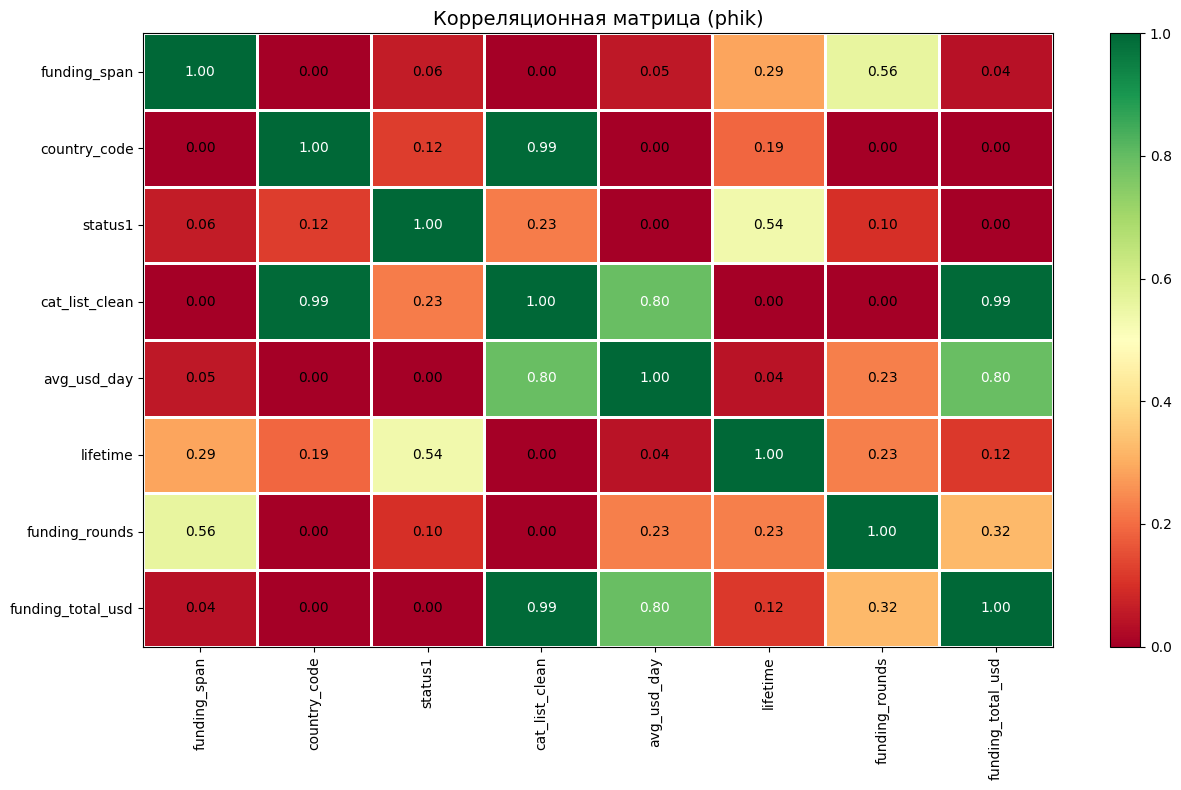

In [84]:
cols = ['funding_total_usd', 'funding_rounds', 'lifetime', 'avg_usd_day', 'cat_list_clean', 'status1', 'country_code', 'funding_span']
data_phik = df[cols]

interval_columns = ['funding_total_usd', 'lifetime', 'avg_usd_day', 'funding_span']
# Вычисляем корреляционную матрицу с использованием phik
phik_corr = data_phik.phik_matrix(interval_cols=interval_columns)
#Визуализация корреляционной матрицы
plot_correlation_matrix(
    phik_corr.values,
    x_labels=phik_corr.columns,
    y_labels=phik_corr.index,
    figsize=(13, 8),
    vmin=0,
    vmax=1,
    title="Корреляционная матрица (phik)"
)

## 4. Подготовка данных

In [175]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,country_code_encoded,closed_at_filled,lifetime,avg_usd_day,funding_span
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0.000076,2018-01-01,2998,276.392929,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0.565943,2018-01-01,4748,9042.758846,1393
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0.000762,2018-01-01,4383,8089.523386,681
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,0.565943,2018-01-01,5114,4350.801721,1051
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0.028114,2018-01-01,2791,NaN,0


In [134]:
country_freq = df['country_code'].value_counts() / len(df)
df['country_code_encoded'] = df['country_code'].map(country_freq)

country_freq2 = test['country_code'].value_counts() / len(test)
df['country_code_encoded'] = test['country_code'].map(country_freq2)


In [94]:
df[(df['category_list'].isna()) & (df['status'] == 'operatng')]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,closed_at_filled,lifetime,avg_usd_day,cat_list_clean,status1,funding_span,country_code_encoded
26,The Center from Health Promotion,NaN,10000000.0,operating,NaN,NaN,NaN,NaN,1,2002-04-21,2003-11-12,2003-11-12,NaT,2018-01-01,5734,1743.983258,,0,0,NaN
64,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-02-22,2011-02-01,2011-02-01,NaT,2018-01-01,3235,NaN,,0,0,NaN
92,ImageScan Inc.,NaN,1550000.0,operating,USA,CA,SF Bay Area,Sausalito,1,2005-10-09,2007-02-26,2007-02-26,NaT,2018-01-01,4467,346.989031,,0,0,0.565580
120,ManeStreem,NaN,100000.0,operating,NaN,NaN,NaN,NaN,1,2014-10-22,2014-11-01,2014-11-01,NaT,2018-01-01,1167,85.689803,,0,0,NaN
158,Little Bird GmbH,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-01-01,2014-10-01,2014-10-01,NaT,2018-01-01,3287,NaN,,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52394,Ogg Trading,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-26,2015-06-01,2015-06-01,NaT,2018-01-01,1436,NaN,,0,0,NaN
52400,Associa,NaN,NaN,operating,USA,TX,Dallas,Dallas,1,1979-01-01,2008-06-11,2008-06-11,NaT,2018-01-01,14245,NaN,,0,0,0.565580
52467,Thermal Nomad,NaN,NaN,operating,USA,TX,Houston,Houston,1,2014-04-20,2014-05-28,2014-05-28,NaT,2018-01-01,1352,NaN,,0,0,0.565580
52473,Vision Software PTY,NaN,15000000.0,operating,NaN,NaN,NaN,NaN,1,1998-01-10,1999-11-02,1999-11-02,NaT,2018-01-01,7296,2055.921053,,0,0,NaN


In [ ]:
num_features = ['funding_rounds', 'lifetime',
               'avg_usd_day', 'funding_span', 'country_code_encoded']


In [ ]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Признаки
num_features = ['funding_total_usd', 'lifetime', 'avg_usd_day']


# Подпайплайны
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)



# Комбинируем
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Финальный пайплайн с oversampling
clf_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    LogisticRegression()
)


In [98]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,closed_at_filled,lifetime,avg_usd_day,cat_list_clean,status1,funding_span,country_code_encoded
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2018-01-01,2998,276.392929,Online_Reservations Restaurants,0,1310,0.004989
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,2018-01-01,4748,9042.758846,Manufacturing Medical Medical_Devices,0,1393,0.565580
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,2018-01-01,4383,8089.523386,Biotechnology,0,681,0.565580
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,2018-01-01,5114,4350.801721,Health_Care,0,1051,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2018-01-01,2791,NaN,Manufacturing,0,0,0.565580


## Ver. 1

In [176]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_features = ['lifetime', 'avg_usd_day', 'funding_rounds', 'funding_span']
X_num = df[num_features].values


In [179]:
from scipy.sparse import hstack

X = df[num_features]
y = df['status1']

# Обработка пропусков (вместо Scaling)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score



# Делим
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42, stratify=y)

# Обучение
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")


F1-score: 0.3710


## Ver. 2

In [128]:
clf = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Предсказание
y_pred = clf.predict(X_test)
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

F1-score: 0.5689


## Ver. 3

In [129]:
num_features = ['lifetime', 'avg_usd_day', 'funding_rounds', 'funding_span']
X_num = df[num_features].values

# Импутация и масштабирование
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_num_imputed = num_imputer.fit_transform(X_num)
X_num_scaled = scaler.fit_transform(X_num_imputed)

X_final = hstack([X_cat_tfidf1, X_num_scaled])  # Sparse + Dense
y = df['status1']

# Делим
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42, stratify=y)

# Обучение
model3 = LogisticRegression(class_weight='balanced', max_iter=1000)
model3.fit(X_train, y_train)

# Предсказание
y_pred3 = model3.predict(X_test)
print(f"F1-score: {f1_score(y_test, y_pred3):.4f}")

F1-score: 0.4303


## Ver. 4

In [130]:
clf3 = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
clf3.fit(X_train, y_train)

# Предсказание
y_pred3 = clf3.predict(X_test)
print(f"F1-score: {f1_score(y_test, y_pred3):.4f}")

F1-score: 0.6003


In [132]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


## Ver2 kaggle submission 1

In [148]:
X_kaggle = test[num_features]
X_kaggle_imputed = imputer.transform(X_kaggle) 

In [151]:
# Предсказание
kaggle_preds = clf.predict(X_kaggle_imputed)


In [153]:
submission = pd.DataFrame({
    'name': test['name'], 
    'status': np.where(kaggle_preds == 1, 'closed', 'operating')
})

submission.to_csv('submission.csv', index=False)


In [154]:
submission

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,closed


## Ver. 5

In [156]:
!pip install imbalanced-learn


python(82555) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [158]:
df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,country_code_encoded
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,0.000076
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,0.565943
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,0.000762
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN,0.565943
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,0.028114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN,NaN
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaN,NaN
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN,NaN
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN,NaN


In [180]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

# Признаки
features = ['lifetime', 'avg_usd_day', 'funding_rounds', 'funding_span']
X_raw = df[features]
y_raw = df['status1']  # Таргет (0 — operating, 1 — closed)

# Импутация
num_imputer = SimpleImputer(strategy='median')
X_filled = num_imputer.fit_transform(X_raw)

# Делим данные
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_filled, y_raw, test_size=0.3, random_state=42, stratify=y_raw
)

# Применяем SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_base, y_train_base)

# Обучение модели
tree_clf = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
tree_clf.fit(X_train_bal, y_train_bal)

# Предсказание
y_val_pred = tree_clf.predict(X_val_base)
print(f"F1-score: {f1_score(y_val_base, y_val_pred):.4f}")


F1-score: 0.6189


/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Ver5 kaggle submission 2

In [184]:

# Загружаем test.csv

# Отбираем нужные числовые признаки
num_features = ['lifetime', 'avg_usd_day', 'funding_rounds', 'funding_span']
X_test_final = test[num_features]

# Используем обученный ранее imputor
X_test_imputed = imputer.transform(X_test_final)

# Предсказание
y_test_pred23 = tree_clf.predict(X_test_imputed)

# Формируем DataFrame с id и предсказанием (если в test.csv есть ID, например 'id')
submission23 = pd.DataFrame({
    'name': test['name'],  # заменишь на нужный идентификатор
    'status': np.where(y_test_pred23 == 1, 'closed', 'operating')
})

# Сохраняем
submission23.to_csv('submission12.csv', index=False)
